In [1]:
# %matplotlib widget

import os
import re
from collections import defaultdict
import jsonlines
import matplotlib.pyplot as plt
import numpy as np

def parse_data_to_dictionary(folder_path = "experiment_data"):
    # Corrected pattern to match filenames and extract information
    filename_pattern = re.compile(
        r"(?P<transmitter>\w+)_"
        r"(?P<blocker>\w+)_"
        r"(?P<tx_power>-?\d+)dBm(?P<block_power>-?\d+)dBm_"
        r"(?P<tx_freq>\d+)MHz(?P<block_freq>\d+)MHz"
    )

    # Dictionary to store grouped data by transmitter_blocker
    grouped_files = defaultdict(list)

    # Parse filenames in the folder
    for filename in os.listdir(folder_path):
        match = filename_pattern.match(filename)
        if match:
            data = match.groupdict()
            # Extract and convert data
            data["tx_power"] = int(data["tx_power"])
            data["block_power"] = int(data["block_power"])
            data["tx_freq"] = int(data["tx_freq"])
            data["block_freq"] = int(data["block_freq"])
            data["frequency_offset"] = data["block_freq"] - data["tx_freq"]
            data["filename"] = filename

            # Group by transmitter_blocker
            transmitter_blocker = f"{data['transmitter']}_{data['blocker']}"
            grouped_files[transmitter_blocker].append(data)

    # Sort each group first by frequency offset, then by blocker power
    for transmitter_blocker, files in grouped_files.items():
        # First sort by frequency offset
        files.sort(key=lambda x: x["frequency_offset"])
        # Then within each frequency offset, sort by blocker power
        files.sort(key=lambda x: (x["frequency_offset"], x["block_power"]))

    return grouped_files


# ----------------------------------------------------------------------------
def load_reference_message(transmitter_filename, reference_folder = "reference_messages"):
    # Construct the full path to the reference message file
    file_path = os.path.join(reference_folder, transmitter_filename)

    with jsonlines.open(file_path) as reader:
        reference_message = reader.read()["message"]
    
    return reference_message
    

def count_bit_errors_one_message(reference_message, message_bytes):
    # Initialize error counts
    bit_error_counts = [0] * (len(reference_message) * 8)  # For each bit in the message

    # Ensure messages are of equal length for comparison
    if len(reference_message) != len(message_bytes):
        raise ValueError("Message lengths do not match!")
    
    # Calculate bit errors by comparing each byte of the reference message and received message
    for byte_index, (ref_byte, msg_byte) in enumerate(zip(reference_message, message_bytes)):
        # Perform XOR operation between the reference byte and the message byte
        error_bits = ref_byte ^ msg_byte

        # Count bit errors by checking each bit position in the error_bits
        for bit_index in range(8):  # There are 8 bits in a byte
            if error_bits & (1 << bit_index): # 1 << 3 = 0x00001000 
                # Increment error count for the specific bit position
                # bit_error_counts : LSB -> MSB, as sent on air
                bit_error_counts[byte_index * 8 + bit_index] += 1

    return bit_error_counts

def read_and_calculate_bit_errors(file_path, reference_message, start_blocking_bit, end_blocking_bit):
    # Initialize total bit errors and cumulative bit error counts
    cumulative_bit_error_distribution = [0] * (len(reference_message) * 8)  # Initialize cumulative counts for all bit positions
    total_packets = 0
    avg_rssi = 0
    packets_desynched = 0
    BER_list_per_packet = [] # Store here the BER for each packet in the blocking section (used to compute standard deviation)

    with jsonlines.open(file_path) as reader:
        for line in reader:
            message_bytes = line["message"]
            
            # Calculate bit errors with respect to the reference message

            if len(reference_message) != len(message_bytes):
                continue
            bit_error_counts = count_bit_errors_one_message(reference_message, message_bytes)
            avg_rssi += line["rssi"]

            # ---------- BER per packet ----------
            BER_current_packet = np.mean(bit_error_counts[start_blocking_bit:end_blocking_bit])
            BER_list_per_packet.append(BER_current_packet)

            # ---------- Did the receiver get out of sync? ----------
            tolerance = 70 # bits
            # if there are bit errors after the interference has ended
            if sum(bit_error_counts[end_blocking_bit + tolerance:]) > 0:
                packets_desynched += 1

            # Add to the total bit errors and accumulate the bit error counts
            for i in range(len(cumulative_bit_error_distribution)):
                cumulative_bit_error_distribution[i] += bit_error_counts[i]

            # Add to the total packets counter
            total_packets += 1
            
    packets_desynched_percentage = float(packets_desynched) / total_packets
    avg_rssi = float(avg_rssi) / total_packets

    return BER_list_per_packet, cumulative_bit_error_distribution, total_packets, avg_rssi, packets_desynched_percentage


# ----------------------------------------------------------------------------
def add_bit_errors_to_files_dict(files_dict, folder="experiment_data", reference_folder="reference_messages"):
    # Process each group and file
    for transmitter_blocker_group, files in files_dict.items():
        for file in files:
            # Extract file details
            filename = file["filename"]
            transmitter = file["transmitter"]

            # Load reference message from the transmitter file
            reference_message = load_reference_message(f"{transmitter}.jsonl", reference_folder)

            # Blocking segments measured from digital analyser
            # Determining blocking segments based on digital analyser and SDR measurements
            if transmitter == "BLE1MBit":
                start_blocking_bit = 145
                if file["blocker"] == "IEEE802154250Kbit":
                    blocked_bits = int(80.65625 * 8)
                elif file["blocker"] == "tone":
                    blocked_bits = int(80.59375 * 8)
                elif file["blocker"] == "BLE1MBit":
                    blocked_bits = int(79.82025 * 8)
                else:
                    print("Error: Undefined blocking configuration!")
                    return
            elif transmitter == "IEEE802154250Kbit":
                start_blocking_bit = 152
                if file["blocker"] == "BLE1MBit":
                    blocked_bits = int(33.9550625 * 8)
                elif file["blocker"] == "tone":
                    blocked_bits = int(33.994125 * 8)
                elif file["blocker"] == "IEEE802154250Kbit":
                    blocked_bits = int(44.16603125 * 8)
                else:
                    print("Error: Undefined blocking configuration!")
                    return
            else:
                print("Error: Undefined transmitter configuration!")
                return
            
            
            # Message length in bits (length of reference message * 8)
            length_id_bits = 4 * 8
            message_length_bits = len(reference_message) * 8 
            payload_length_bits = length_id_bits + message_length_bits

            end_blocking_bit = start_blocking_bit + int(blocked_bits)

            # Calculate bit error metrics
            BER_list_per_packet, bit_error_distribution_cumulative, total_packets, avg_rssi, packets_desynched_percentage = read_and_calculate_bit_errors(
                os.path.join(folder, filename), reference_message, start_blocking_bit, end_blocking_bit
            )

            # Compute the average BER only within the blocking interval
            avg_ber = np.mean(np.array(BER_list_per_packet))
            std_ber = np.std(np.array(BER_list_per_packet)) 

            # Add calculated metrics to the file dictionary
            file["bit_error_distribution_cumulative"] = [
                x / total_packets * 100 for x in bit_error_distribution_cumulative
            ]
            file["ber_avg"] = avg_ber * 100
            file["ber_std"] = std_ber * 100
            file["avg_rssi"] = avg_rssi
            file["packets_desynched_percentage"] = packets_desynched_percentage * 100


def format_title(transmitter, blocker):
    """Format the transmitter_blocker_group string into a clean title."""
    mapping = {
        "BLE1MBit": "BLE",
        "IEEE802154250Kbit": "IEEE 802.15.4",
        "tone":  "tone",
    }
    return mapping.get(transmitter, transmitter), mapping.get(blocker, blocker)

# ----------------------------------------------------------------------------
# Function to create grouped bar plots as subplots
def plot_grouped_ber_with_subplots(
    files_dict, 
    bar_width=0.15, 
    figsize=(12, 3.5), 
    log_scale=False, 
    saveas=None, 
    max_legend_col=10, 
    legend_vskip=0.9, 
    plot_BER=True, 
    ylabel="Bit error rate (%)",
    unpack_value="ber_avg"
):

    # Determine the maximum y-axis value across all groups for uniformity
    max_y_value = 0
    ber_data_by_group = {}

    # First pass: Calculate BER and find max value for y-axis
    for transmitter_blocker_group, files in files_dict.items():
        grouped_data = {}
        for file in files:
            freq_offset = file["frequency_offset"]
            if freq_offset not in grouped_data:
                grouped_data[freq_offset] = []
            grouped_data[freq_offset].append(file)

        sorted_offsets = sorted(grouped_data.keys())
        blocker_powers = sorted(set(file["block_power"] for file in files))
        group_ber_data = []

        for block_power in blocker_powers:
            avg_ber_values = []
            std_ber_values = []
            for freq_offset in sorted_offsets:
                power_files = [
                    f for f in grouped_data[freq_offset]
                    if f["block_power"] == block_power
                ]
                avg_ber_values.append(power_files[0][unpack_value] if power_files else np.nan)
                std_ber_values.append(power_files[0]["ber_std"] if power_files else np.nan)

            group_ber_data.append((block_power, avg_ber_values, std_ber_values))
            max_y_value = max(max_y_value, *avg_ber_values)

        ber_data_by_group[transmitter_blocker_group] = (sorted_offsets, blocker_powers, group_ber_data)

    # Plotting: Create subplots for each group
    num_groups = len(ber_data_by_group)
    fig, axes = plt.subplots(1, num_groups, figsize=figsize, sharey=True)

    # Ensure axes is always iterable
    if num_groups == 1:
        axes = [axes]

    for i, (ax, (transmitter_blocker_group, (sorted_offsets, blocker_powers, group_ber_data))) in enumerate(zip(axes, ber_data_by_group.items())):
        x_positions = np.arange(len(sorted_offsets))
        colours = plt.cm.tab10(np.tile(np.linspace(0, 1, 10), len(blocker_powers) // 10 + 1)[:len(blocker_powers)])

        for idx, (block_power, avg_ber_values, std_ber_values) in enumerate(group_ber_data):
            bar_positions = x_positions + (idx - len(blocker_powers) / 2) * bar_width
            # Plot bars
            ax.bar(
                bar_positions,
                avg_ber_values,
                width=bar_width,
                color=colours[idx],
                label=f"{block_power} dBm",
                alpha=0.8,
            )
            if unpack_value == "ber_avg":
                # Plot standard deviations
                # Add standard deviation error bars
                ax.errorbar(
                    bar_positions,
                    avg_ber_values,
                    yerr=std_ber_values,
                    fmt="none",  # No marker, just error bars
                    capsize=3,  # Size of error bar caps
                    color="black",  # Error bar color
                    elinewidth=1,  # Error bar line width
                )

            

        transmitter, blocker = transmitter_blocker_group.split("_")
        transmitter, blocker = format_title(transmitter, blocker)

        ax.set_title(f'{transmitter}, {blocker} interferer')
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"{offset} MHz" for offset in sorted_offsets])
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        # Set y-axis to logarithmic or linear scale with uniform max y value
        if plot_BER:
            if log_scale:
                ax.set_yscale("log")
                ax.set_ylim(1e-4, max_y_value * 2)  # Use a small positive value for the lower limit
            else:
                ax.set_ylim(0, max_y_value * 1.1)

        ax.set_xlabel("Frequency Offset (MHz)")

        # Set y-label only for the leftmost plot
        if i == 0:
            ax.set_ylabel(ylabel)

    # Add legend outside the plots for clarity
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=min(len(blocker_powers), max_legend_col),  # Adjust to wrap automatically
        title="Interferer power (dBm)",
        frameon=False,
    )
    fig.tight_layout(rect=[0, 0, 1, legend_vskip])  # Adjust layout for the legend

    if saveas:
        fig.savefig(saveas, format="pdf", bbox_inches="tight")

    plt.show()


# ----------------------------------------------------------------------------
# Function to plot cumulative bit errors for multiple files
def plot_cumulative_bit_errors_array(example_files, figsize=(12, 6), saveas=False, ylabel="Bit error probability per bit position (%)"):
    def format_title(transmitter, blocker):
        """Map the transmitter and blocker names to the desired format."""
        mapping = {
            "BLE1MBit": "BLE",
            "IEEE802154250Kbit": "IEEE 802.15.4",
            "tone": "Tone",
        }
        return mapping.get(transmitter, transmitter), mapping.get(blocker, blocker)

    # Number of files determines the number of subplots
    num_files = len(example_files)
    fig, axes = plt.subplots(1, num_files, figsize=figsize, sharey=True)

    # Ensure `axes` is iterable for a single subplot case
    if num_files == 1:
        axes = [axes]

    max_y_value = 0
    # Loop to determine the global max y-value for consistent scaling
    for file in example_files:
        max_y_value = max(max_y_value, max(file["bit_error_distribution_cumulative"]))

    # Loop over files and plot each one
    for i, (ax, file) in enumerate(zip(axes, example_files)):
        transmitter, blocker = format_title(file["transmitter"], file["blocker"])
        cumulative_errors = file["bit_error_distribution_cumulative"]
        bit_positions = range(len(cumulative_errors))

        ax.plot(bit_positions, cumulative_errors, color="blue", alpha=0.7, label="Cumulative Errors")
        ax.fill_between(bit_positions, cumulative_errors, color="blue", alpha=0.3)  # Fill the area under the curve

        freq_offset = file['block_freq'] - file['tx_freq']
        ax.set_title(f"{transmitter} {file['tx_power']} dBm,\n{blocker} {file['block_power']} dBm,\n{freq_offset} Hz")
        ax.set_xlabel("Bit Position")
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        # Set y-axis limit for consistency
        ax.set_ylim(0, max_y_value * 1.1)

        # Set x-axis limit to ensure arrays take the full width of each subplot
        ax.set_xlim(0, len(cumulative_errors) - 1)

        # Set y-label only on the leftmost plot
        if i == 0:
            ax.set_ylabel(ylabel)

    # Adjust layout to prevent overlapping titles
    fig.tight_layout()

    if saveas:
        fig.savefig(saveas, format="pdf", bbox_inches="tight")

    plt.show()


# ----------------------------------------------------------------------------
# Function to create grouped bar plots as subplots with sideband zoom-in
def plot_grouped_ber_with_subplots_scaled_sidebands(
    files_dict, 
    bar_width=0.15, 
    figsize=(12, 3.5), 
    log_scale=False, 
    saveas=None, 
    max_legend_col=10, 
    legend_vskip=0.9, 
    plot_BER=True, 
    ylabel="Bit error rate (%)",
    unpack_value="ber_avg",
    scaling_side_factor=50  # New parameter: scale sideband values by this factor
):

    # Initialize overall maximums for main (0 MHz) and sideband (nonzero) values.
    max_y_value = 0
    main_max_value = 0
    sideband_max_value = 0
    ber_data_by_group = {}

    # First pass: Calculate BER data per group and find max values for y-axis limits
    for transmitter_blocker_group, files in files_dict.items():
        grouped_data = {}
        for file in files:
            freq_offset = file["frequency_offset"]
            if freq_offset not in grouped_data:
                grouped_data[freq_offset] = []
            grouped_data[freq_offset].append(file)

        sorted_offsets = sorted(grouped_data.keys())
        blocker_powers = sorted(set(file["block_power"] for file in files))
        group_ber_data = []

        for block_power in blocker_powers:
            avg_ber_values = []
            std_ber_values = []
            for freq_offset in sorted_offsets:
                power_files = [
                    f for f in grouped_data[freq_offset]
                    if f["block_power"] == block_power
                ]
                if power_files:
                    value = power_files[0][unpack_value]
                    avg_ber_values.append(value)
                    std_ber_values.append(power_files[0]["ber_std"])
                    # Update main or sideband maximums (note: these are the unscaled values)
                    if freq_offset == 0:
                        main_max_value = max(main_max_value, value)
                    else:
                        sideband_max_value = max(sideband_max_value, value)
                else:
                    avg_ber_values.append(np.nan)
                    std_ber_values.append(np.nan)
            group_ber_data.append((block_power, avg_ber_values, std_ber_values))
            max_y_value = max(max_y_value, *avg_ber_values)

        ber_data_by_group[transmitter_blocker_group] = (sorted_offsets, blocker_powers, group_ber_data)

    # For plotting purposes, the primary y-axis will span the larger of:
    #  - the main band values (unscaled) and 
    #  - the sideband values scaled by scaling_side_factor.
    combined_y_max = max(main_max_value, sideband_max_value * scaling_side_factor)

    # Plotting: Create subplots for each group
    num_groups = len(ber_data_by_group)
    fig, axes = plt.subplots(1, num_groups, figsize=figsize, sharey=True)

    # Ensure axes is always iterable
    if num_groups == 1:
        axes = [axes]

    for i, (ax, (transmitter_blocker_group, (sorted_offsets, blocker_powers, group_ber_data))) in enumerate(zip(axes, ber_data_by_group.items())):
        x_positions = np.arange(len(sorted_offsets))
        colours = plt.cm.tab10(np.tile(np.linspace(0, 1, 10), len(blocker_powers) // 10 + 1)[:len(blocker_powers)])

        for idx, (block_power, avg_ber_values, std_ber_values) in enumerate(group_ber_data):
            bar_positions = x_positions + (idx - len(blocker_powers) / 2) * bar_width
            # For each frequency offset, scale sidebands (freq != 0) by scaling_side_factor
            scaled_avg = []
            scaled_std = []
            for j, offset in enumerate(sorted_offsets):
                if offset != 0:
                    scaled_avg.append(avg_ber_values[j] * scaling_side_factor)
                    scaled_std.append(std_ber_values[j] * scaling_side_factor)
                else:
                    scaled_avg.append(avg_ber_values[j])
                    scaled_std.append(std_ber_values[j])
            # Plot bars using the scaled values
            ax.bar(
                bar_positions,
                scaled_avg,
                width=bar_width,
                color=colours[idx],
                label=f"{block_power} dBm",
                alpha=0.8,
            )
            if unpack_value == "ber_avg":
                # Plot error bars individually, using blue for sidebands and black for the main band.
                for j, offset in enumerate(sorted_offsets):
                    err_color = "blue" if offset != 0 else "black"
                    ax.errorbar(
                        bar_positions[j],
                        scaled_avg[j],
                        yerr=scaled_std[j],
                        fmt="none",  # No marker, just error bars
                        capsize=3,
                        color=err_color,
                        elinewidth=1,
                    )

        # Titles and x-axis formatting
        transmitter, blocker = transmitter_blocker_group.split("_")
        transmitter, blocker = format_title(transmitter, blocker)
        ax.set_title(f'{transmitter}, {blocker} interferer')
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"{offset} MHz" for offset in sorted_offsets])
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        ax.set_xlabel("Frequency Offset (MHz)")

        # Set y-axis to logarithmic or linear scale with uniform max y value.
        if plot_BER:
            if log_scale:
                ax.set_yscale("log")
                # For log scale, ensure lower limit is a small positive number.
                ax.set_ylim(1e-4, combined_y_max * 2)
            else:
                ax.set_ylim(0, combined_y_max * 1.1)

        # Add the secondary y-axis only to the rightmost plot
        if i == len(axes) - 1:
            secax = ax.secondary_yaxis(
                'right', 
                functions=(lambda y: y / scaling_side_factor, lambda y: y * scaling_side_factor)
            )
            # Do not set any label text for the secondary axis
            secax.tick_params(axis="y", colors="blue")
            if sideband_max_value > 0:
                secax.set_ylim(0, sideband_max_value * 1.1)

        # Set y-label only for the leftmost plot (primary axis label)
        if i == 0:
            ax.set_ylabel(ylabel)

    # Add legend outside the plots for clarity (using handles from the last axis)
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=min(len(blocker_powers), max_legend_col),
        title="Interferer power (dBm)",
        frameon=False,
    )
    fig.tight_layout(rect=[0, 0, 1, legend_vskip])  # Adjust layout for the legend

    if saveas:
        fig.savefig(saveas, format="pdf", bbox_inches="tight")

    plt.show()



In [2]:
filename = "experiment_data/inter_protocol_2425MHz"

# Parse file names into dictionaries
files_dict = parse_data_to_dictionary(filename)

# Add bitt error distribution, count and BER to each configuration (file)
add_bit_errors_to_files_dict(files_dict, filename, reference_folder="reference_messages2")



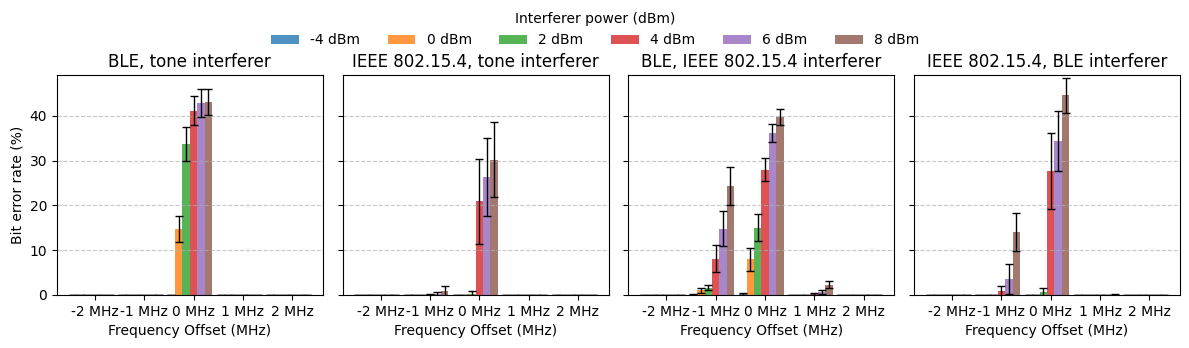

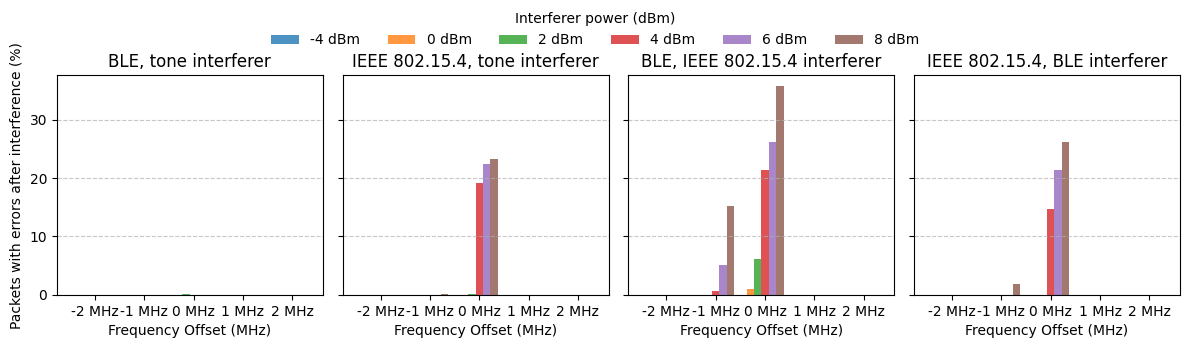

In [3]:
# Call the function
plot_grouped_ber_with_subplots(files_dict, 
                               plot_BER=True, 
                               saveas="BER_plot_all.pdf")

plot_grouped_ber_with_subplots(files_dict, plot_BER=False, 
                               ylabel="Packets with errors after interference (%)",
                               unpack_value="packets_desynched_percentage",
                               saveas="sync_plot_all.pdf")


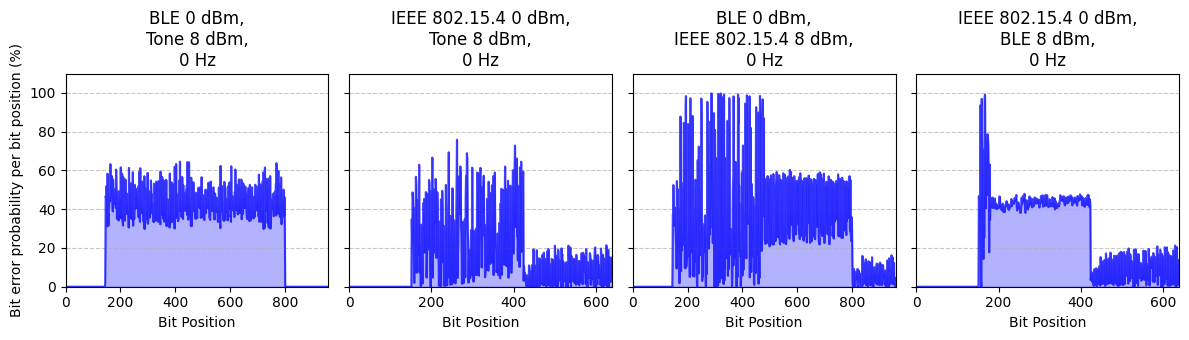

In [4]:
# Example: Plot for an array of files
example_files = [
    files_dict["BLE1MBit_tone"][17],
    files_dict["IEEE802154250Kbit_tone"][17],
    files_dict["BLE1MBit_IEEE802154250Kbit"][17],
    files_dict["IEEE802154250Kbit_BLE1MBit"][17],
]
plot_cumulative_bit_errors_array(example_files, figsize=(12, 3.5),
                                 saveas="bit_error_patterns_all.pdf")


# Same protocol blocking

In [5]:
# filename = "experiment_data/same_protocol_2425MHz_tx-20dBm"
filename = "experiment_data/same_protocol_2425MHz_tx-40dBm"
# Parse file names into dictionaries
files_dict_same = parse_data_to_dictionary(filename)

# Add bitt error distribution, count and BER to each configuration (file)
add_bit_errors_to_files_dict(files_dict_same, filename, reference_folder="reference_messages2")

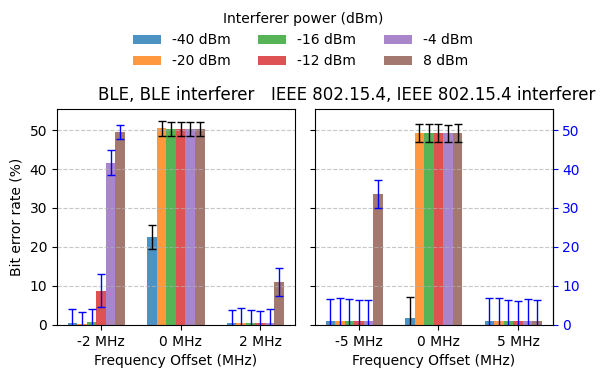

In [6]:

plot_grouped_ber_with_subplots_scaled_sidebands(files_dict_same, 
                               bar_width=0.12, 
                               figsize=(6,3.8), 
                               log_scale=False, 
                               saveas="BER_plot_same.pdf",
                               max_legend_col=3,
                               legend_vskip=0.82,
                               plot_BER=True,                              
                               scaling_side_factor=1 )


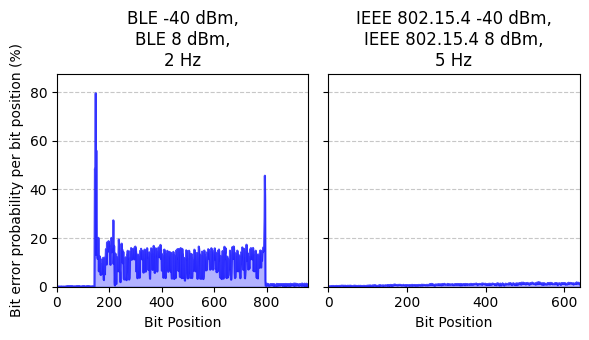

In [7]:
# Example: Plot for an array of files
example_file_same = [
    files_dict_same["BLE1MBit_BLE1MBit"][17],
    files_dict_same["IEEE802154250Kbit_IEEE802154250Kbit"][17],
]
plot_cumulative_bit_errors_array(example_file_same, figsize=(6,3.5))